# Intermittent control as a model of mouse movements 

## Full parameter set

This notebook provides visualisations of the Intermittent Control (IC) parameters (full set) which were obtained from an optimisation procedure based on an experimental pointing task. The data file used by this notebook contains the optimised parameters for each condition (8 in total) for the 12 participants. In the file, the values of all the parameters obtained for a particular slice are listed and grouped according to target distance and width. The file was generated in MATLAB and it is imported to Python using a Pandas dataframe. 

This notebook is part of the supplemental material for publication in ACM Transactions on Computer-Human Interaction (https://dl.acm.org/journal/tochi)

This work is based on the results of the following paper:

- Müller, Jörg, Antti Oulasvirta, and Roderick Murray-Smith. "Control
theoretic models of pointing." ACM Transactions on Computer-Human
Interaction (TOCHI) 24, no. 4 (2017): 27.

### Requirements

Please install the CRETools-0.1.0 package before running this jupyter
notebook as follows:

* Go to the folder CRETools-0.1.0 and build the package with: python setup.py sdist
* In the same folder, use the following line to install it: python setup.py install

The notebook also needs the following dependencies:

* umap-learn (https://pypi.org/project/umap-learn/)
* numpy (https://numpy.org/)
* seaborn (https://seaborn.pydata.org/)
* pandas (https://pandas.pydata.org/)
* scipy (https://www.scipy.org/)
* universal-divergence (https://pypi.org/project/universal-divergence/)

# 1. Load the full set of optimised parameters

The first step is to read the data file (opt_data_full_20200111T075641.mat) that contains all the parameters for all participants. Once loaded, a Pandas dataframe (df) is created. The following cell assigns names to each column of the dataframe and performs some necessary operations on the data.

The parameters that were extracted from the optimisation procedure are: 

- 1) Thresholds $q$. 
- 2) Mismatch gain $A_p$.
- 3) Open-loop interval $\Delta_{ol}$.
- 4) The diagonal of the LQR design matrix $Q_c$, which weights the states of the model. This diagonal contains 4 elements and they are labelled as $Q_{c_1}$, $Q_{c_2}$, $Q_{c_3}$ and $Q_{c_4}$.
- 5) The observer design matrix $Q_o$.

Since the LQR procedure results in the generation of a set of controller gains which are used to generate a control signal via state-feedback, they were included in the dataframe as $k_1$, $k_2$, $k_3$ and $k_4$.


In [1]:
# --- Load libraries
from __future__ import print_function
from universal_divergence import estimate
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import umap
import copy
import scipy.io as spio
from scipy import stats
from sklearn import preprocessing
from cre import io as loader
from KDEpy import FFTKDE

%matplotlib inline

# --- Paper context for Seaborn
sns.set(style='white', context='paper', font_scale=1.5, rc={'figure.figsize':(12, 8), 'figure.facecolor':'w'})

# --- Load data file (generated using matlab)
df = loader.loadmat(r'data_files/opt_data_full_20200111T075641.mat')

# --- Create pandas dataframe df
df = pd.DataFrame(df['df'])
df.columns = ["Participant", "Slice", "Threshold", "Ap","OL","Qc1","Qc2","Qc3","Qc4","Qo","k1","k2","k3","k4","J_slice","J_trial","Distance","Width","ID"]

# --- Change the mismatch gain to reflect the difference with respect to the true plant.
df['Ap'] = 1-df['Ap']

# --- Convert ID, distance, width, and Participant to integers only
df['ID'] = df['ID'].astype(int)
df['Distance'] = df['Distance'].astype(int)
df['Width'] = df['Width'].astype(int)
df['Participant'] = df['Participant'].astype(int)

# --- Removing large thresholds and OL's
df = df.drop(df[df.Threshold > 0.03].index)
df = df.drop(df[df.OL > 0.06].index)
df = df.drop(df[df.Ap < -0.3].index)
df = df.drop(df[df.J_slice > 0.025].index)
df = df.drop(df[df.J_trial > 0.04].index)

# 2. Scatter plots

First, we take the entire dataframe (df) and we use the pairplot function from Seaborn to create general scatter plots for some of the parameters: control gains, thresholds, open-loop intervals and mismatch gain.

### 2.1. $k$, $q$, $\Delta_{ol}$ and $A_p$ classified by Index of Difficulty (ID)
The following figure shows scatter plots colored according to the index of difficulty of the task. An ID value of 2 indicates an easier task (wide targets) whereas a value of 8 corresponds to the most difficult one (narrow targets).

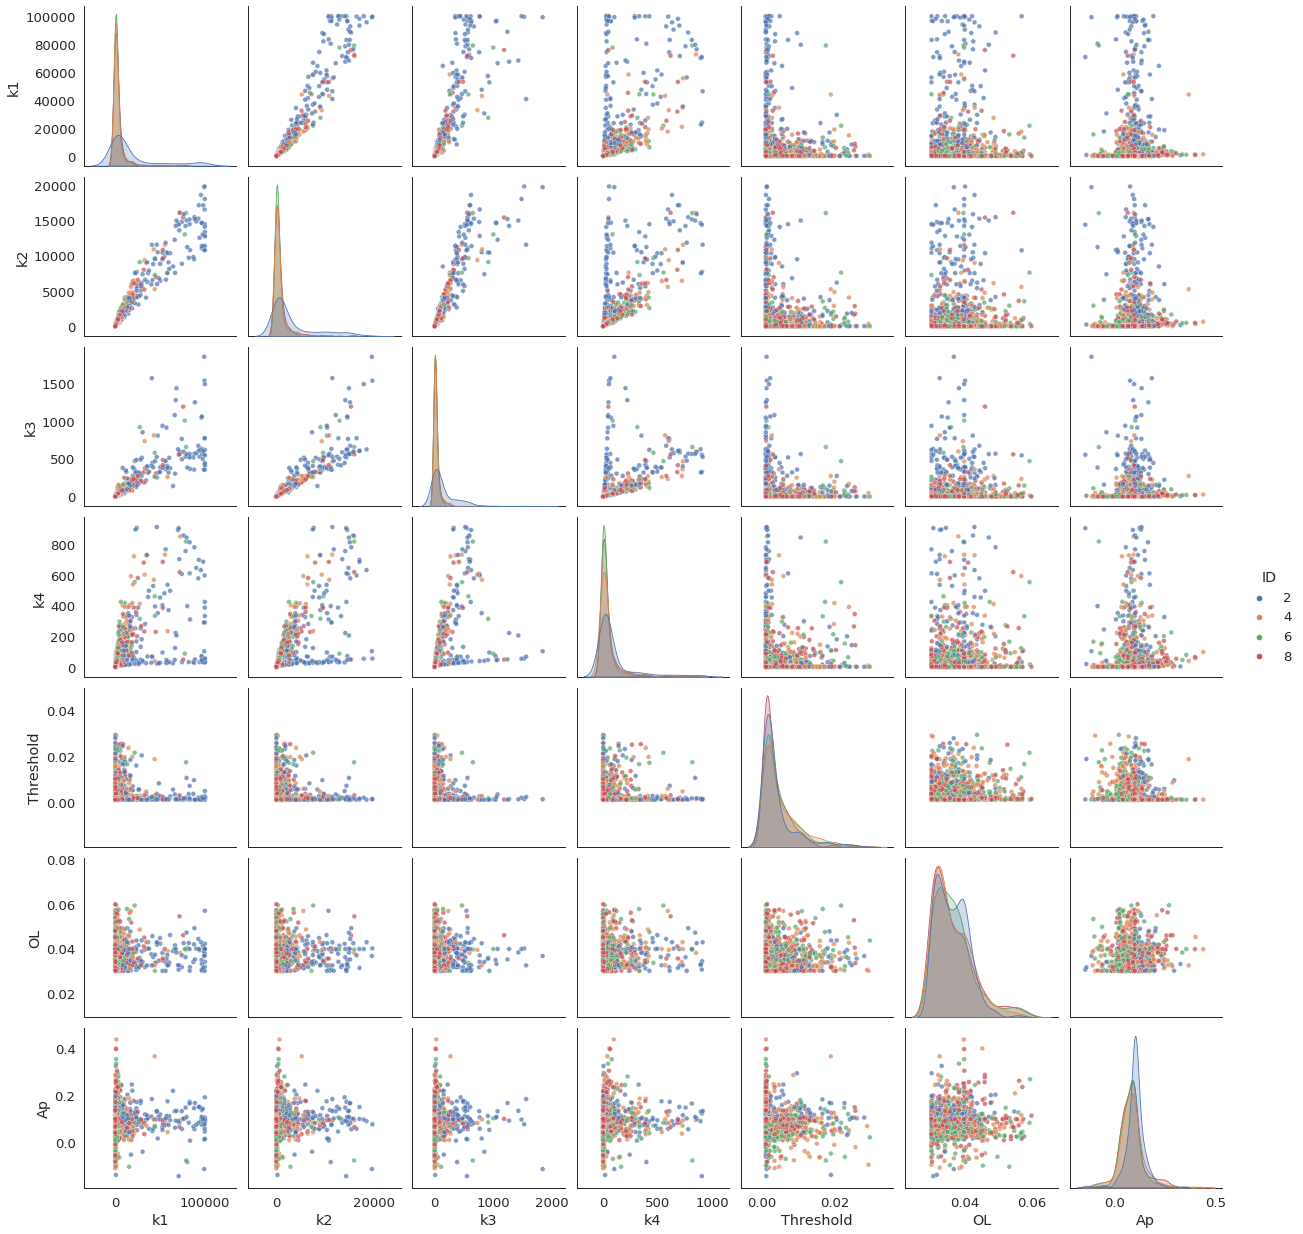

In [2]:
sns.pairplot(df, hue='ID', palette="deep", plot_kws={'alpha':0.7}, vars=["k1", "k2", "k3", "k4", "Threshold", "OL", "Ap"])

### 2.2. $k$, $q$, $\Delta_{ol}$ and $A_p$ classified by distance

The following figure shows scatter plots colored according to the distance between targets. In this case, two distances were used in the experiment: 765 and 1275 pixels (212 and 353 mm).

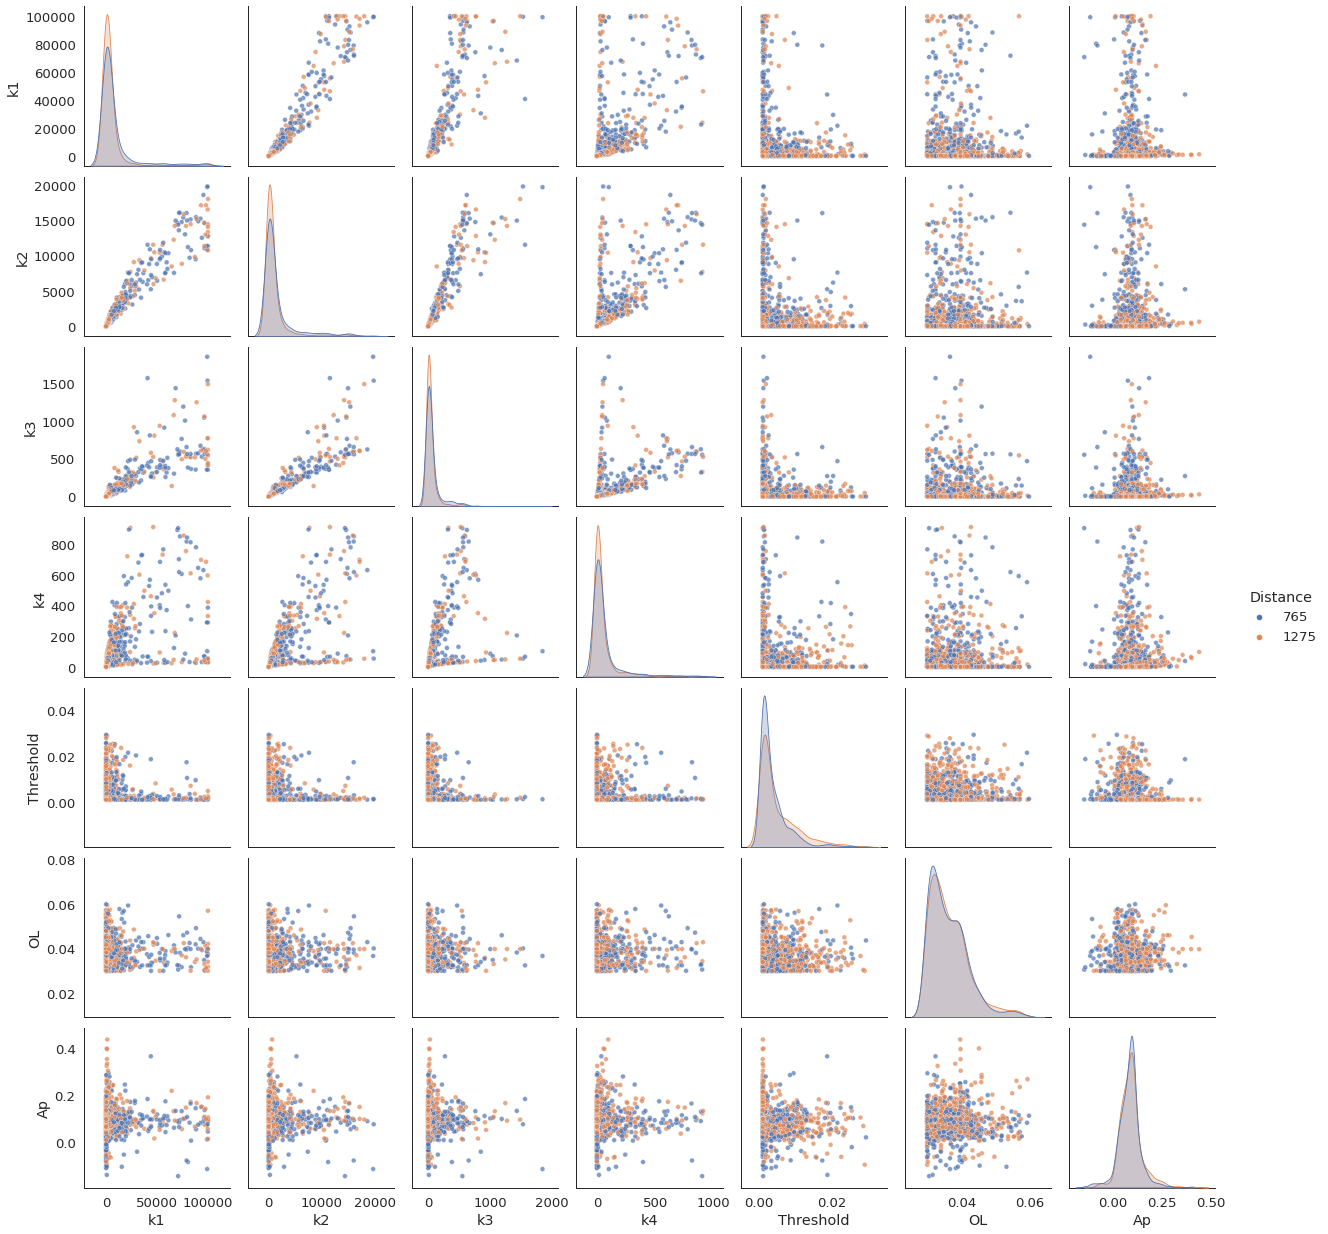

In [3]:
sns.pairplot(df, hue='Distance', palette="deep", plot_kws={'alpha':0.7}, vars=["k1", "k2", "k3", "k4", "Threshold", "OL", "Ap"])

### 2.3. $k$, $q$, $\Delta_{ol}$ and $A_p$ classified by participant

The following figure shows scatter plots colored according to each of the participants in the experiment.

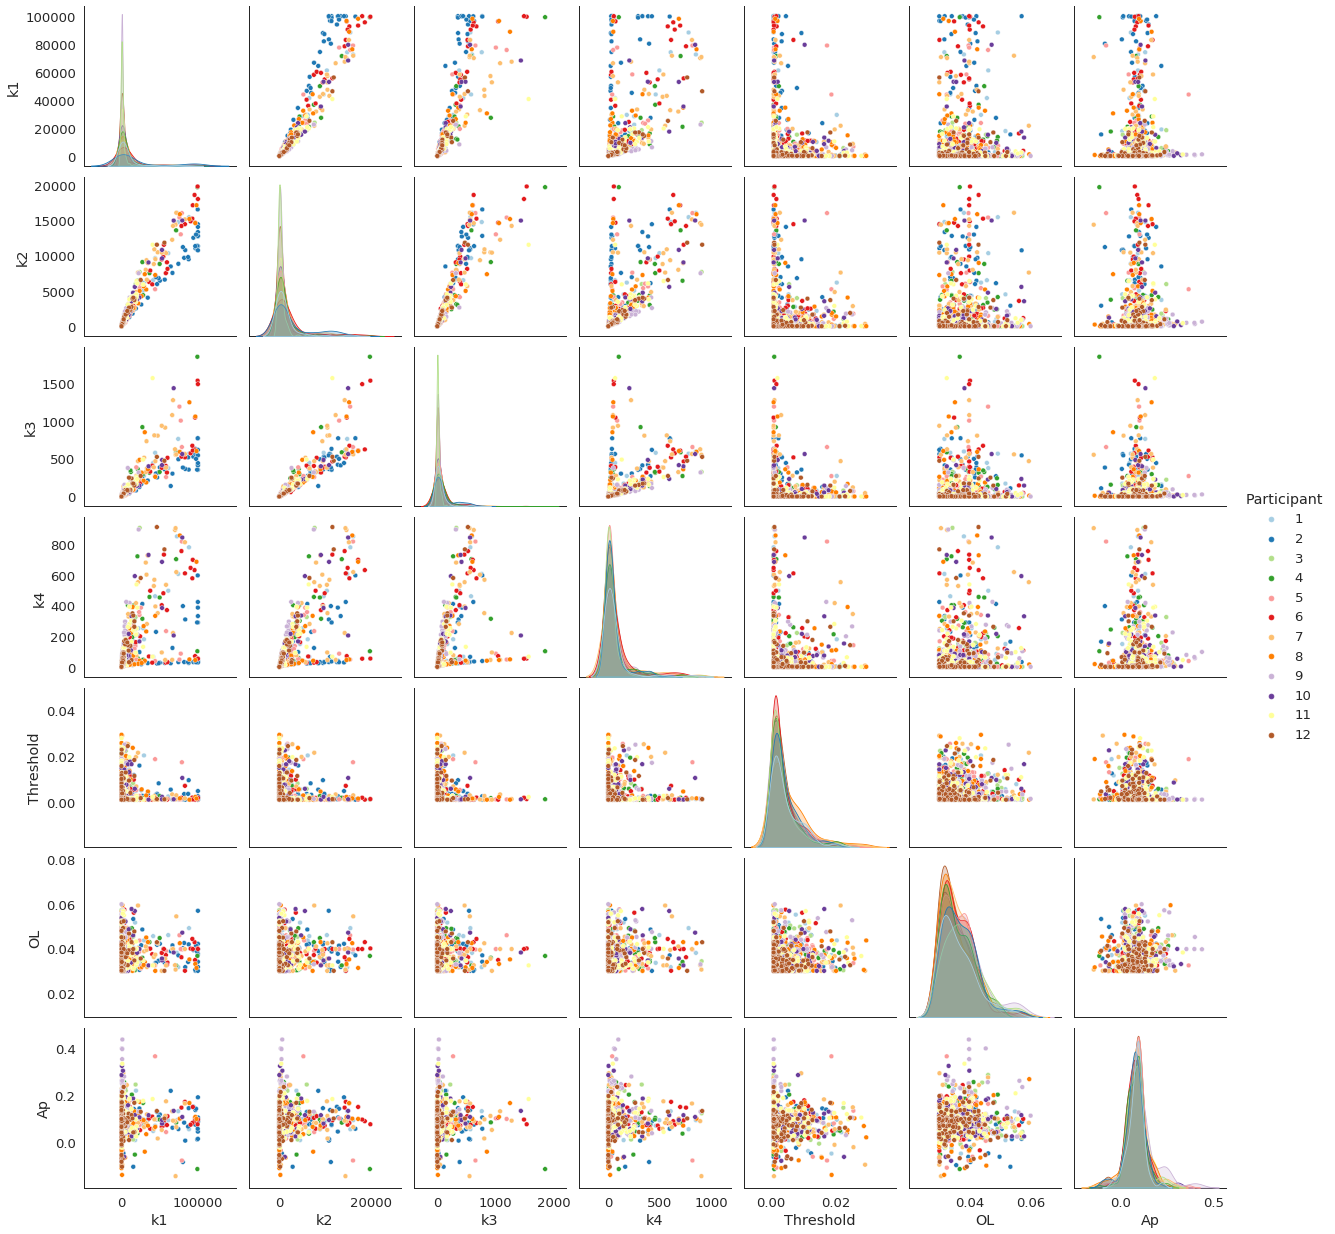

In [4]:
sns.pairplot(df, hue='Participant', palette="Paired", vars=["k1", "k2", "k3", "k4", "Threshold", "OL", "Ap"])

# 3. Optimisation results

In this section, general violin plots are obtained to give an overall view of the resulting set of parameters from the optimisation process. These figures include parameters for all participants and conditions. The figures are organised as follows:

- 1 by 4 grid showing the four elements in $Q_c$.
- 1 by 4 grid showing the four controller gains ($k_1$, $k_2$, $k_3$, $k_4$).
- 1 by 4 grid showing the rest of the parameters ($A_p$, $\Delta_{ol}$, $q$, $Q_o$).
- 1 by 2 the value of the cost function used during the training of each slice vs the value of the cost function when the optimised parameters of each slice are used to run a simulation over the entire trial (not just the slice).

The x axis of all figures shows the four ID's of the experiment. Each side of the violin plot corresponds to the distribution of one of the two different distances between targets. The distribution on the left side is for a distance of 212mm, the one on the right is for 353mm.

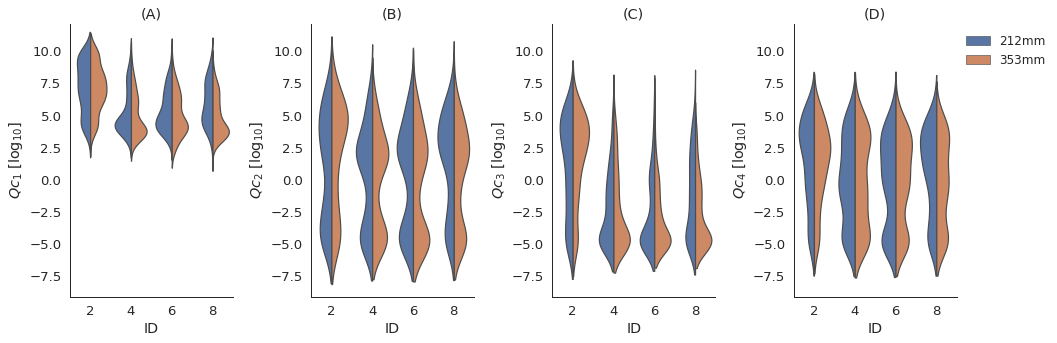

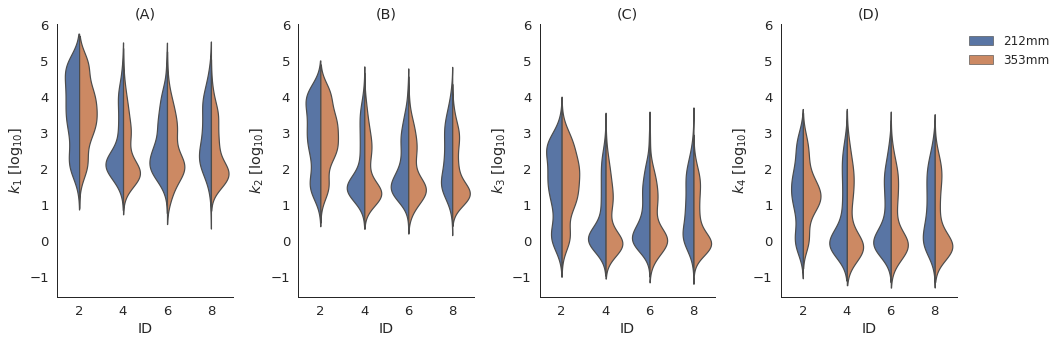

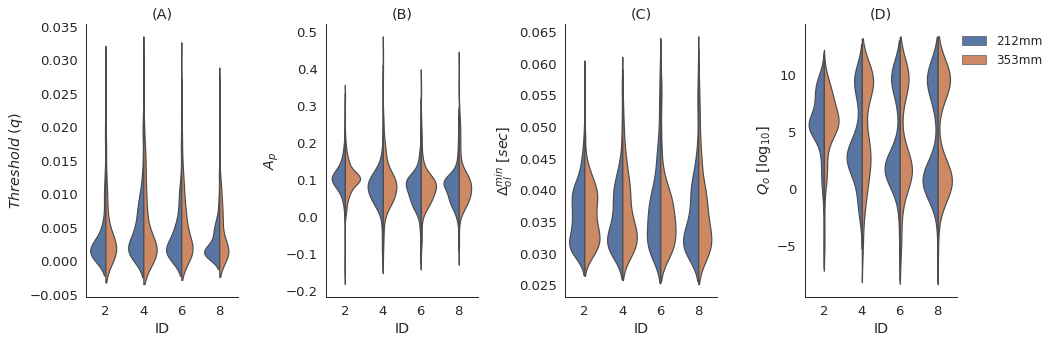

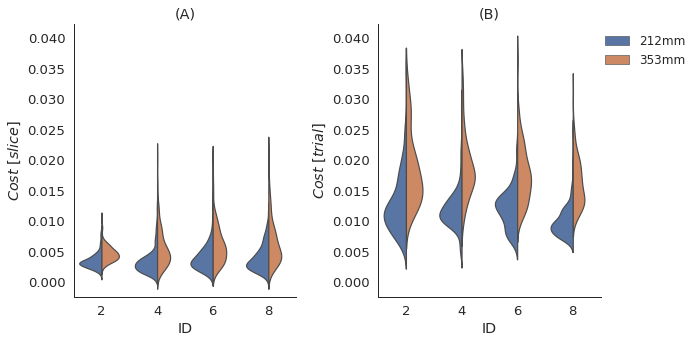

In [5]:
# --- These variables control the appearance of the violin plots
bw_kde = 'silverman'    # Automatic bandwidth selection by Silverman's method.
cut_data = 2;           # 2 is the default
y_suptitle = 1.02
save_violin = False     # Save figure or not.
 
# --- Special Dataframes for Violin plots
dfv = copy.deepcopy(df)

# --- Logs of Q's and K's
dfv['Qc1'] = np.log10(dfv['Qc1']); dfv['Qc2'] = np.log10(dfv['Qc2'])
dfv['Qc3'] = np.log10(dfv['Qc3']); dfv['Qc4'] = np.log10(dfv['Qc4'])
dfv['k1'] = np.log10(dfv['k1']); dfv['k2'] = np.log10(dfv['k2'])
dfv['k3'] = np.log10(dfv['k3']); dfv['k4'] = np.log10(dfv['k4'])
dfv['Qo'] = np.log10(dfv['Qo'])

# --- Labels
title_labels = ['A','B','C','D']; 
axis_labels_Qc = ['$Qc_1$ $[\log_{10}]$','$Qc_2$ $[\log_{10}]$','$Qc_3$ $[\log_{10}]$','$Qc_4$ $[\log_{10}]$']
axis_labels_k = ['$k_1$ $[\log_{10}]$','$k_2$ $[\log_{10}]$','$k_3$ $[\log_{10}]$','$k_4$ $[\log_{10}]$']
axis_labels_ic = ['$Threshold$ $(q)$','$A_p$','$\Delta_{ol}^{min}$ $[sec]$','$Q_o$ $[\log_{10}]$']
axis_labels_J = ['$Cost$ $[slice]$','$Cost$ $[trial]$']

# --- Definition of plotting functions
def violin_pars_row(params, df, cut_data, bw_kde, title_labels, axis_labels, par_sel, save_fig):
    fig, axes = plt.subplots(figsize=(15, 5))
    ymin_all = []; ymax_all = []; g_all = []
    for x in range(len(params)):
        plt.subplot(1,4,x+1)
        g = sns.violinplot(x="ID", y=params[x], hue="Distance", data=df, cut = cut_data, bw = bw_kde, split=True, inner=None)
        g_all.append(g)
        if x < 4:
            plt.title('('+title_labels[x]+')')
        if par_sel != 'ic':
            y_min, y_max = g.axes.get_ylim()
            ymin_all.append(y_min); ymax_all.append(y_max)
        cax = plt.gca()
        cax.set_ylabel(axis_labels[x])
        cax.spines["right"].set_visible(False)
        cax.spines["top"].set_visible(False)
        cax.legend_ = None
        if x == 3:
            plt.legend(['212mm', '353mm'], prop={'size': 12}, frameon=False, loc='upper center', bbox_to_anchor=(1.3, 1))
    if par_sel != 'ic':
        for y in range(len(params)):
            g_all[y].axes.set_ylim(min(ymin_all),max(ymax_all)) 
    fig.tight_layout()
    if save_fig == True:
        fig.savefig('violin_all_row_'+par_sel+'.eps',dpi=300)
        
def violin_cost(params, df, cut_data, bw_kde, title_labels, axis_labels, par_sel, save_fig):    
    fig, axes = plt.subplots(figsize=(10, 5))
    ymin_all = []; ymax_all = []; g_all = []
    for x in range(len(params)):
        plt.subplot(1,2,x+1)
        g = sns.violinplot(x="ID", y=params[x], hue="Distance", data=df, cut = cut_data, bw = bw_kde, split=True, inner=None)
        g_all.append(g)
        if x < 2:
            plt.title('('+title_labels[x]+')')
        y_min, y_max = g.axes.get_ylim()
        ymin_all.append(y_min); ymax_all.append(y_max)    
        cax = plt.gca()
        cax.set_ylabel(axis_labels_J[x])
        cax.spines["right"].set_visible(False)
        cax.spines["top"].set_visible(False)
        cax.legend_ = None
        if x == 1:
            plt.legend(['212mm', '353mm'], prop={'size': 12}, frameon=False, loc='upper center', bbox_to_anchor=(1.2, 1))
    for y in range(2):
        g_all[y].axes.set_ylim(min(ymin_all),max(ymax_all))    
    fig.tight_layout()
    if save_fig == True:
        fig.savefig('violin_all_'+par_sel+'.eps',dpi=300)

# --- Qc plot row
params = ['Qc1','Qc2','Qc3','Qc4']
violin_pars_row(params, dfv, cut_data, bw_kde, title_labels, axis_labels_Qc, 'Qc', save_violin)

# --- k plot row
params = ['k1','k2','k3','k4']
violin_pars_row(params, dfv, cut_data, bw_kde, title_labels, axis_labels_k, 'k', save_violin)

# --- Rest of the parameters plot in a row
params = ['Threshold','Ap','OL','Qo']
violin_pars_row(params, dfv, cut_data, bw_kde, title_labels, axis_labels_ic, 'ic', save_violin)

# --- Cost plot
params = ['J_slice','J_trial']
violin_cost(params, dfv, cut_data, bw_kde, title_labels, axis_labels_J, 'J', save_violin)

# 4. Actual and minimum Open-loop interval histograms

In this section, the actual open-loop intervals (generated by IC in simulation) and the minimum open-loop interval (optimised parameter) for all participants and conditions are shown in the form of histograms.

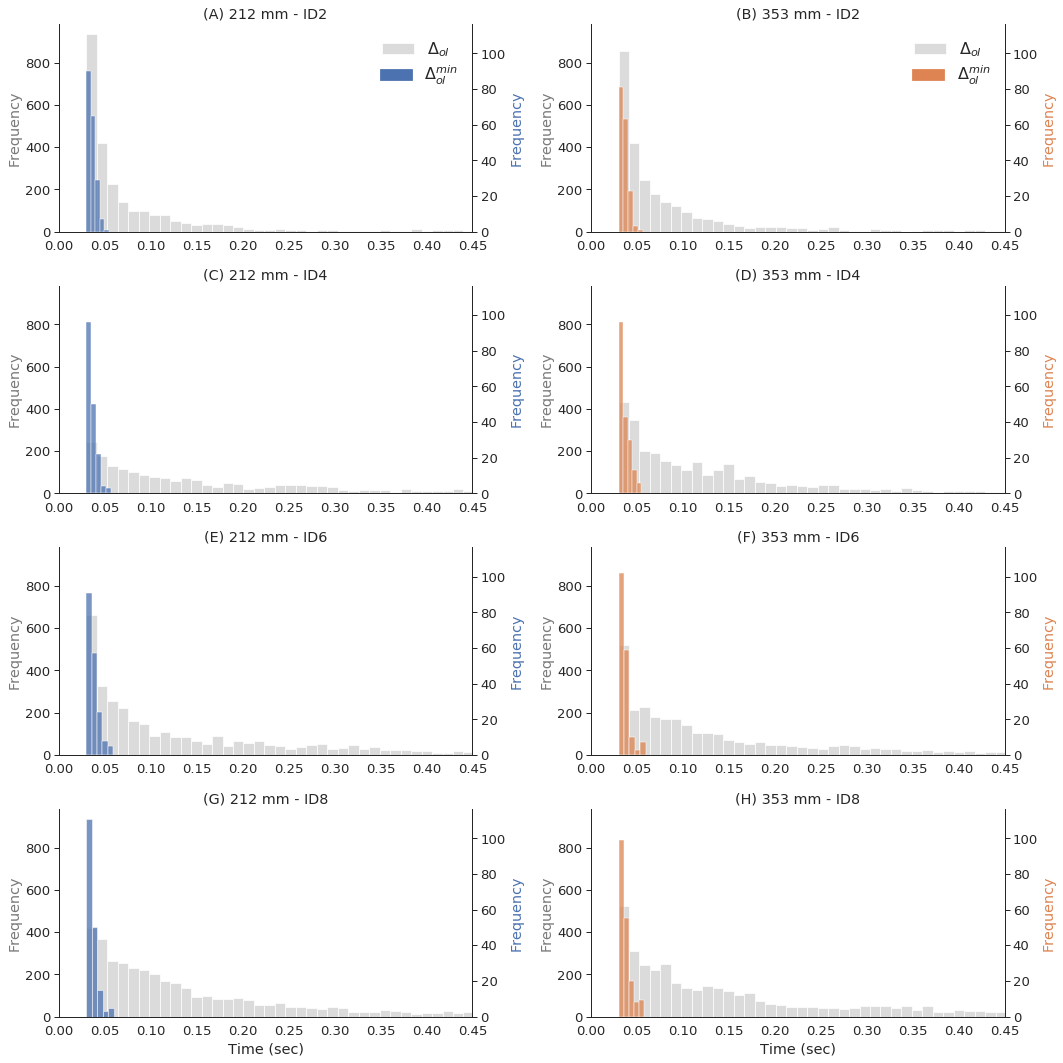

In [6]:
# --- Important parameters
xcut = 0.02                   # Defines the left boundary for the kde on the x axis

# --- Save figure
save_ol = False

# --- ACTUAL OPEN-LOOP INTERVALS 
dfol = loader.loadmat(r'data_files/ol_intervals_20201211T144909.mat')
dfol_con_1 = dfol['OLS']['con_1']; dfol_con_2 = dfol['OLS']['con_2']
dfol_con_3 = dfol['OLS']['con_3']; dfol_con_4 = dfol['OLS']['con_4']
dfol_con_5 = dfol['OLS']['con_5']; dfol_con_6 = dfol['OLS']['con_6']
dfol_con_7 = dfol['OLS']['con_7']; dfol_con_8 = dfol['OLS']['con_8']

dfol1 = pd.DataFrame(data=dfol_con_1); dfol2 = pd.DataFrame(data=dfol_con_2)
dfol3 = pd.DataFrame(data=dfol_con_3); dfol4 = pd.DataFrame(data=dfol_con_4)
dfol5 = pd.DataFrame(data=dfol_con_5); dfol6 = pd.DataFrame(data=dfol_con_6)
dfol7 = pd.DataFrame(data=dfol_con_7); dfol8 = pd.DataFrame(data=dfol_con_8)

ol1 = np.ravel(dfol1.to_numpy()); ol2 = np.ravel(dfol2.to_numpy())
ol3 = np.ravel(dfol3.to_numpy()); ol4 = np.ravel(dfol4.to_numpy())
ol5 = np.ravel(dfol5.to_numpy()); ol6 = np.ravel(dfol6.to_numpy())
ol7 = np.ravel(dfol7.to_numpy()); ol8 = np.ravel(dfol8.to_numpy())

ol1 = ol1[ol1>xcut]; ol2 = ol2[ol2>xcut]
ol3 = ol3[ol3>xcut]; ol4 = ol4[ol4>xcut]
ol5 = ol5[ol5>xcut]; ol6 = ol6[ol6>xcut]
ol7 = ol7[ol7>xcut]; ol8 = ol8[ol8>xcut]

ols = [ol1,ol2,ol3,ol4,ol5,ol6,ol7,ol8]
title_labels = ['(A) 212 mm - ID2','(B) 353 mm - ID2','(C) 212 mm - ID4','(D) 353 mm - ID4','(E) 212 mm - ID6','(F) 353 mm - ID6','(G) 212 mm - ID8','(H) 353 mm - ID8']

# --- OPTIMISED PARAMETERS
dfvOLS = dfv[['OL','Distance','ID']].copy()

dfvOLS_2_765 = dfvOLS[(dfvOLS['ID'] == 2) & (dfvOLS['Distance'] == 765)]
dfvOLS_4_765 = dfvOLS[(dfvOLS['ID'] == 4) & (dfvOLS['Distance'] == 765)]
dfvOLS_6_765 = dfvOLS[(dfvOLS['ID'] == 6) & (dfvOLS['Distance'] == 765)]
dfvOLS_8_765 = dfvOLS[(dfvOLS['ID'] == 8) & (dfvOLS['Distance'] == 765)]

dfvOLS_2_1275 = dfvOLS[(dfvOLS['ID'] == 2) & (dfvOLS['Distance'] == 1275)]
dfvOLS_4_1275 = dfvOLS[(dfvOLS['ID'] == 4) & (dfvOLS['Distance'] == 1275)]
dfvOLS_6_1275 = dfvOLS[(dfvOLS['ID'] == 6) & (dfvOLS['Distance'] == 1275)]
dfvOLS_8_1275 = dfvOLS[(dfvOLS['ID'] == 8) & (dfvOLS['Distance'] == 1275)]

OLdf = [dfvOLS_2_765, dfvOLS_2_1275, dfvOLS_4_765, dfvOLS_4_1275, dfvOLS_6_765, dfvOLS_6_1275, dfvOLS_8_765, dfvOLS_8_1275]

# --- Plot
fig, ax1 = plt.subplots(figsize=(15, 15))
ymin_all = []; ymax_all = []; g_all = []; ymin_all_2 = []; ymax_all_2 = []; g_all_2 = []
for i in range(0,8):
    data = ols[i]    
    ax1 = plt.subplot(4,2,i+1)
    if i < 8:
           plt.title(title_labels[i])
    
    # --- Plot histogram for the actual open-loop interval
    ax1 = sns.histplot(data = data, bins=50, binrange={0.03,0.6}, color=sns.color_palette("pastel")[7])
        
    if i > 5:
        ax1.set_xlabel("Time (sec)")
    ax1.set_ylabel("Frequency", color=sns.color_palette("muted")[7])
    ax1.set_xlim([0,0.45])
    ax1.set_ylim([0,None])
    
    # --- Plot histogram for minimum open-loop interval
    ax2 = ax1.twinx()
    onlyOL = OLdf[i]
    min_ol = onlyOL['OL'].min()
    
    if i % 2 == 0 or i == 0:
        color_value = 0
    else:
        color_value = 1
    
    ax2 = sns.histplot(data = onlyOL["OL"], bins=5, color=sns.color_palette()[color_value])
    
    ax2.set_ylabel("Frequency", color=sns.color_palette()[color_value])
    
    g_all.append(ax1)
    g_all_2.append(ax2)
    
    y_min, y_max = ax1.axes.get_ylim()
    ymin_all.append(y_min); ymax_all.append(y_max)
    
    y_min_2, y_max_2 = ax2.axes.get_ylim()
    ymin_all_2.append(y_min_2); ymax_all_2.append(y_max_2)
    
    
    ax1.spines["top"].set_visible(False)
    ax2.spines["top"].set_visible(False) 
    
    if i < 2:
        ax1.legend(['$\Delta_{ol}$'], prop={'size': 16}, frameon=False, bbox_to_anchor=(0.98, 0.99))
        texts = ["$\Delta_{ol}^{min}$"]
        patches = [ mpatches.Patch(color=sns.color_palette()[color_value], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
        ax2.legend(handles=patches, prop={'size': 16}, frameon=False, bbox_to_anchor=(1, 0.88))
                
for y in range(0,8):
    g_all[y].axes.set_ylim(min(ymin_all),max(ymax_all))
    g_all_2[y].axes.set_ylim(min(ymin_all_2),max(ymax_all_2))
    
fig.tight_layout()

if save_ol == True:
    fig.savefig('ol-histograms.eps',dpi=300)

# 5. Kullback-Leibler divergence

In this section we will be able to see how different the distributions obtained via simulation are compared to the observed distributions (real data).

The mean Kullback-Leibler values over 20 simulations for the phase-plane data were calculated. To speed up the computations in the KL test, a subsampling approach was taken on the data that was fed to the estimation of the KL values. A preselection of every 10th sample of the position and velocity time-series was used. 

To compute the KL estimates, a Python package called universal-divergence was used, which obtains the estimates from multi-dimensional data arrays based on k-nearest neighbor distances. 

### 5.1 Mean KL values over 20 simulation runs: phase-plane

The results of running 20 simulations in a row are shown. The procedure was as follows:

The KL values are computed for a single simulation and stored for future use, this is done for all the simulation files. At the end, the mean value over the 20 simulations is computed for each condition.

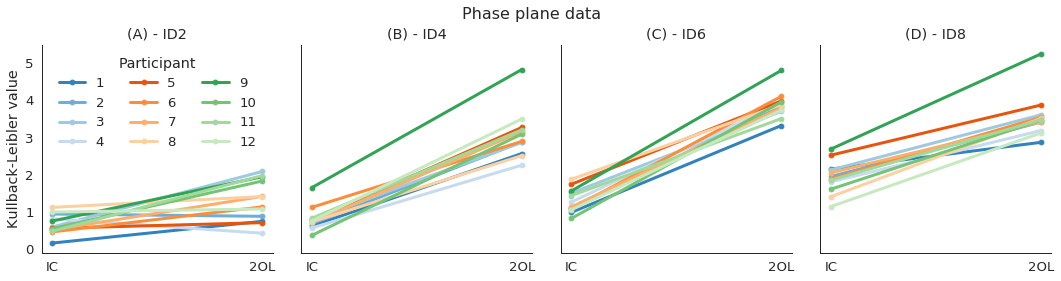

In [7]:
# --- Important variables
part = 12                                 # 12 participants
xval = [0, 1]                             # x range
colors = sns.color_palette("Blues")       # Color palette
save_figure = False                       # Save figure or not
sns.set(style='white', context='paper', font_scale=1.5, rc={'figure.facecolor':'w'})

# --- Import the result files from the kl analysis
df_ic_vs_cc = pd.read_pickle('data_files/kl/kl_values_ic_vs_2ol_10sub.pkl')
df_mean_iter20_phase_plane = pd.read_pickle('data_files/kl/kl_mean_phase_plane_20iter_10sub_avante.pkl')

# --- Generate dataframes
df_cc = df_ic_vs_cc
df_cc = df_cc.drop(['ic-2' ,'ic-4', 'ic-6', 'ic-8'], axis=1)
df_cc.rename(columns={'cc-2':'ID2 - 2OL','cc-4':'ID4 - 2OL','cc-6':'ID6 - 2OL','cc-8':'ID8 - 2OL'}, inplace=True)

df_ic = df_mean_iter20_phase_plane
df_ic.rename(columns={'ID2':'ID2 - IC','ID4':'ID4 - IC','ID6':'ID6 - IC','ID8':'ID8 - IC'}, inplace=True)
df_all = pd.concat([df_ic, df_cc], axis=1, ignore_index=False, sort=False)

# --- Create figure
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, sharey=True, figsize=(15, 4))
fig.suptitle('Phase plane data', fontsize=16)
for i in range(part):
    value1 = df_all['ID2 - IC'].iloc[i]
    value2 = df_all['ID2 - 2OL'].iloc[i]
    yval =  [value1, value2]
    c = cm.tab20c(i)
    ax1.plot(xval, yval, 'o-', lw=3, color=c)
    
ax1.set_title('(A) - ID2')    
ax1.set_ylabel('Kullback-Leibler value')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['IC','2OL'])
ax1.spines["right"].set_visible(False);
ax1.spines['top'].set_visible(False)
ax1.legend([x for x in range(1,13)], frameon=False, loc='upper center', ncol=3, title="Participant")

for i in range(part):
    value1 = df_all['ID4 - IC'].iloc[i]
    value2 = df_all['ID4 - 2OL'].iloc[i]
    yval =  [value1, value2]
    c = cm.tab20c(i)
    ax2.plot(xval, yval, 'o-', lw=3, color=c)
    
ax2.set_title('(B) - ID4')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['IC','2OL'])
ax2.spines["right"].set_visible(False);
ax2.spines['top'].set_visible(False)

for i in range(part):
    value1 = df_all['ID6 - IC'].iloc[i]
    value2 = df_all['ID6 - 2OL'].iloc[i]
    yval =  [value1, value2]
    c = cm.tab20c(i)
    ax3.plot(xval, yval, 'o-', lw=3, color=c)
    
ax3.set_title('(C) - ID6')
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['IC','2OL'])
ax3.spines["right"].set_visible(False);
ax3.spines['top'].set_visible(False)

for i in range(part):
    value1 = df_all['ID8 - IC'].iloc[i]
    value2 = df_all['ID8 - 2OL'].iloc[i]
    yval =  [value1, value2]
    c = cm.tab20c(i)
    ax4.plot(xval, yval, 'o-', lw=3, color=c)
    
ax4.set_title('(D) - ID8')
ax4.set_xticks([0, 1])
ax4.set_xticklabels(['IC','2OL'])
ax4.spines["right"].set_visible(False);
ax4.spines['top'].set_visible(False)

fig.tight_layout()
plt.subplots_adjust(top=0.85)

if save_figure == True:
    plt.savefig('kl_phase-plane_figure.eps', dpi=300)

The following table contains the results KL mean values for the 20 simulations of IC and for the Second Order Lag (2OL) continuous controller. The rows represent the participants whereas the columns are the different conditions.

In [8]:
df_all

,ID2 - IC,ID4 - IC,ID6 - IC,ID8 - IC,ID2 - 2OL,ID4 - 2OL,ID6 - 2OL,ID8 - 2OL
1,0.161263,0.619388,0.987115,2.149580,0.745626,2.567490,3.319502,2.867856
2,0.941403,0.680970,1.092488,1.950400,0.879725,2.881445,3.834312,3.409654
3,0.594746,0.796764,1.504187,2.127719,2.085388,2.867767,3.700626,3.606368
4,0.814038,0.568572,1.264142,1.806650,0.425407,2.255024,3.921890,3.183618
5,0.556905,0.773431,1.742175,2.523686,0.709533,3.267794,3.980110,3.869222
6,0.461370,1.121918,1.086332,1.883233,1.134657,2.893843,4.103803,3.539882
7,0.514605,0.716355,1.134698,2.050049,1.415292,3.158786,3.798831,3.414906
8,1.120593,0.730127,1.877069,1.406643,1.412389,2.510788,3.880548,3.510339
9,0.754197,1.652829,1.563093,2.687486,1.944700,4.824883,4.801666,5.242883
10,0.550343,0.368994,0.824338,1.609132,1.829689,3.090607,3.954932,3.460075


### 5.2 Boxplots of KL values over 20 simulation runs: phase-plane

The following figure takes the values used to compute the mean reported in the previous table and generates a boxplot for each participant and the four conditions. Also, the KL value related to the 2OL controller is shown as a red circle for comparison purposes.

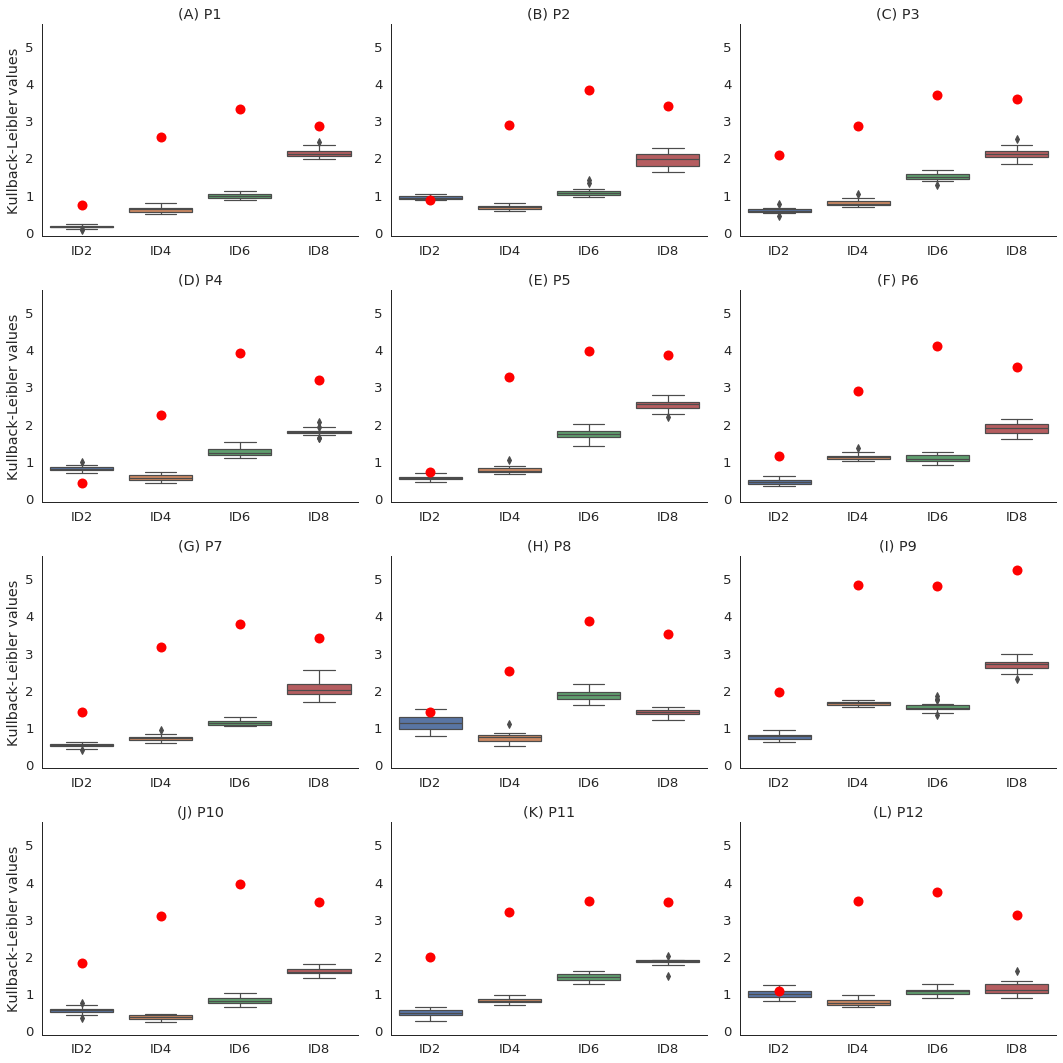

In [9]:
# --- Important variables
part = 12                        # 12 participants
save_figure_boxplot = False      # Save figure or not
sns.set(style='white', context='paper', font_scale=1.5, rc={'figure.facecolor':'w'})
title_labels = ['(A) P1','(B) P2','(C) P3','(D) P4','(E) P5','(F) P6','(G) P7','(H) P8', '(I) P9', '(J) P10', '(K) P11', '(L) P12']
    
# --- Import file    
df_array_iter20_phase_plane = pd.read_pickle('data_files/kl/kl_array_phase_plane_20iter_10sub_avante.pkl')

# --- Create figures
fig, axes = plt.subplots(figsize=(15, 15))   
ymin_all = []; ymax_all = []; g_all = []
for i in range(part):
    plt.subplot(4,3,i+1)
    ID2_P = []; ID4_P = []; ID6_P = []; ID8_P = []; iteration = [];
    for key in df_array_iter20_phase_plane.keys():
        temp_df = df_array_iter20_phase_plane[key]

        ID2_temp = temp_df['ID2'].iloc[i]
        ID4_temp = temp_df['ID4'].iloc[i]
        ID6_temp = temp_df['ID6'].iloc[i]
        ID8_temp = temp_df['ID8'].iloc[i]

        iteration.append(key)
        ID2_P.append(ID2_temp)
        ID4_P.append(ID4_temp)
        ID6_P.append(ID6_temp)
        ID8_P.append(ID8_temp)
  
        df_Part = pd.DataFrame(list(zip(ID2_P, ID4_P, ID6_P, ID8_P)), 
                               columns=['ID2', 'ID4', 'ID6', 'ID8']) 
    
    df_cc.rename(columns={'ID2 - 2OL':'ID2','ID4 - 2OL':'ID4','ID6 - 2OL':'ID6','ID8 - 2OL':'ID8'}, inplace=True)
    df_cc_part = df_cc.iloc[[i]]
    
    if i < part:
        plt.title(title_labels[i])
    g = sns.boxplot(data=df_Part)
    p = sns.swarmplot(data=df_cc_part, color="red", size=10)
    g_all.append(g)
    y_min, y_max = g.axes.get_ylim()
    ymin_all.append(y_min); ymax_all.append(y_max)

    cax = plt.gca()

    if i == 0:
        cax.set_ylabel('Kullback-Leibler values')
    elif i == 3:
        cax.set_ylabel('Kullback-Leibler values')
    elif i == 6:
        cax.set_ylabel('Kullback-Leibler values')
    elif i == 9:
        cax.set_ylabel('Kullback-Leibler values')    
    else:
        cax.set_ylabel('')
        
    cax.spines["right"].set_visible(False);
    cax.spines['top'].set_visible(False)
for y in range(part):
    g_all[y].axes.set_ylim(min(ymin_all),max(ymax_all))

fig.tight_layout()
if save_figure_boxplot == True:
    plt.savefig('kl_boxplots_20iter_10sub_with_cc.eps', dpi=300)
    plt.savefig('kl_boxplots_20iter_10sub_with_cc.png')